In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import os
import logging

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

from __init__ import *
from snmcseq_utils import create_logger
from snmcseq_utils import plot_tsne_values

# from scipy.stats import gaussian_kde

# from snmcseq_utils import plot_tsne_labels
# from snmcseq_utils import tsne_and_boxplot

In [65]:
log = create_logger()

In [66]:

def normalize_by_global(df_mcc, df_meta, context):
    """
    normalize a mcc dataframe by global mcc level
    """
    print('Normalize by global m%s ...' % context)
    df_nmcc = pd.DataFrame()
    
    for idx, row in df_meta.iterrows():
        samp = idx 
        if context == 'CH':
            df_nmcc[samp] = (df_mcc[samp] / (row['mCH/CH']+.01))
        elif context == 'CG':
            df_nmcc[samp] = (df_mcc[samp] / (row['mCG/CG']+.01))
        else:
            raise ValueError('Wrong context: %s' % context)
    return df_nmcc


In [67]:
ens = 'Ens2'
context = 'CH'
ens_path = os.path.join(PATH_ENSEMBLES, ens)
meta_file = os.path.join(ens_path, 'mapping_summary_{}.tsv'.format(ens))
binc_file = os.path.join(ens_path, 'binc/binc_m{}_{}_{}.tsv.bgz'.format(context, ens, BIN_SIZE_FEATURE))

In [68]:
# mch file
context = 'CH'
df = pd.read_table(binc_file, index_col=['chr', 'bin'], 
                   compression='gzip', dtype={'chr': object})
print(df.shape)

(25475, 2540)


In [69]:
df.iloc[:5, :2]

171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A10_AD001_indexed_mc  \
chr bin                                                                                             
1   0                                                       0                                       
    100000                                                  0                                       
    200000                                                  0                                       
    300000                                                  0                                       
    400000                                                  0                                       

            171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A10_AD001_indexed_c  
chr bin                                                                                           
1   0                                                       0                                     
    100000                                                  0                                     
    200000                                                  0                                     
    300000                                                  0                                     
    400000                                                  0

In [70]:
# metadata
df_meta = pd.read_table(meta_file, index_col='Sample')
print(df_meta.shape)

(1270, 14)


In [71]:
df_mc = df.filter(regex='_mc$')
df_c = df.filter(regex='_c$')

df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 

print(df_mc.shape)
print(df_c.shape)

(25475, 1270)
(25475, 1270)


In [72]:
# Filter out bins with low and high coverage ...
# Keep only bins that have sufficient coverage in at least 99.5% of all cells


# low coverage
base_call_cutoff = 100 
sufficient_coverage_fraction = 0.95

base_call_cutoff_v2 = 100 
sufficient_coverage_fraction_v2 = 0.88

high_mean = 1200

condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
condition3 = (df_c > base_call_cutoff_v2).sum(axis=1) >= sufficient_coverage_fraction_v2*df_c.shape[1] 
# high coverage
condition2 = df_c.mean(axis=1) < high_mean 
condition = ((condition1 | (condition3 & (df_c.index.get_level_values(0)=='X'))) & condition2)

df_f = df.loc[condition]
print("Matrix size before pruning... "+ str(df.shape))
print("Matrix size after pruning... "+ str(df_f.shape))
print("Fraction of bins passing thresholds: "+ str(df_f.shape[0]/df.shape[0]))
print("Matrix size before pruning for chrX... "+ str(df[df.index.get_level_values(0)=='X'].shape))
print("Matrix size after pruning for chrX... "+ str(df_f[df_f.index.get_level_values(0)=='X'].shape))
print("Fraction of bins passing thresholds for chrX: "+ 
      str(df_f[df_f.index.get_level_values(0)=='X'].shape[0]/df[df.index.get_level_values(0)=='X'].shape[0]))

# get mcc matrix with kept bins and nan values for low coverage sites
# df_c_nan = df_c.copy()
# df_c_nan[df_c < base_call_cutoff] = np.nan
# df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]

df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
# df_c_nan = df_c_nan[condition]
nonnulls = 1 - df_c_nan.isnull()

fbins = nonnulls.sum(axis=1)/nonnulls.shape[1]
fcells = nonnulls.sum(axis=0)/nonnulls.shape[0]

print("Mean cells {}".format(fbins.mean()))
print("Mean bins {}".format(fcells.mean()))

Matrix size before pruning... (25475, 2540)
Matrix size after pruning... (23807, 2540)
Fraction of bins passing thresholds: 0.9345240431795878
Matrix size before pruning for chrX... (855, 2540)
Matrix size after pruning for chrX... (610, 2540)
Fraction of bins passing thresholds for chrX: 0.7134502923976608
Mean cells 0.9288673935385162
Mean bins 0.9288673935385161


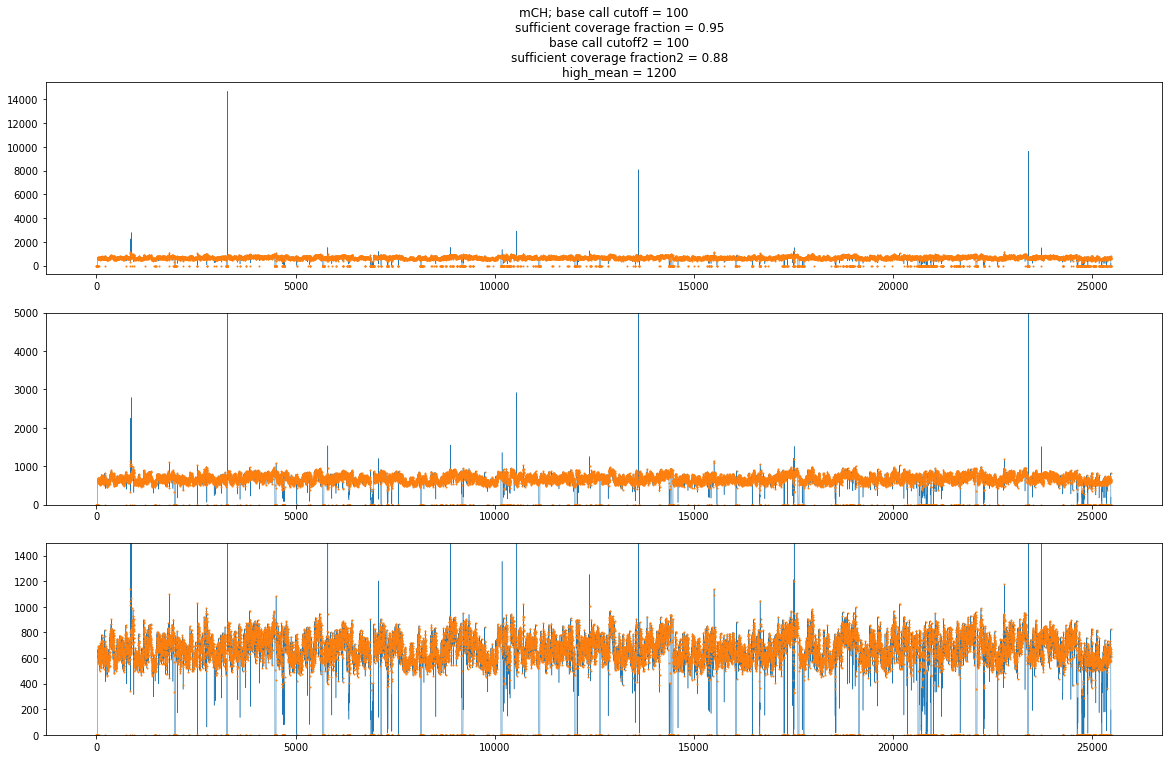

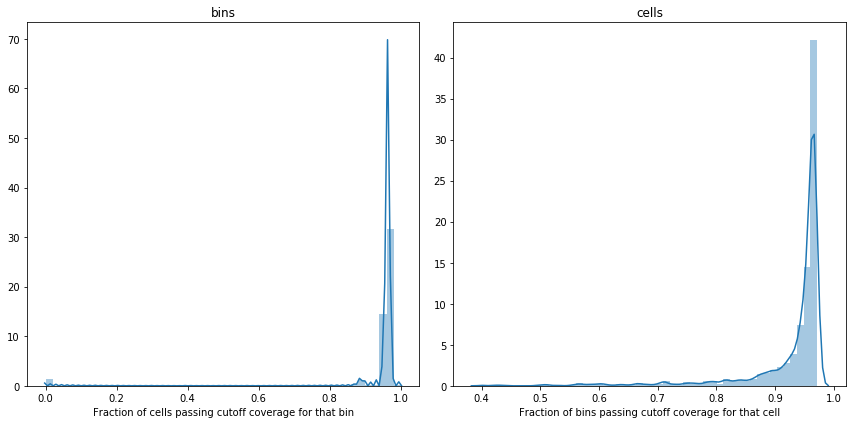

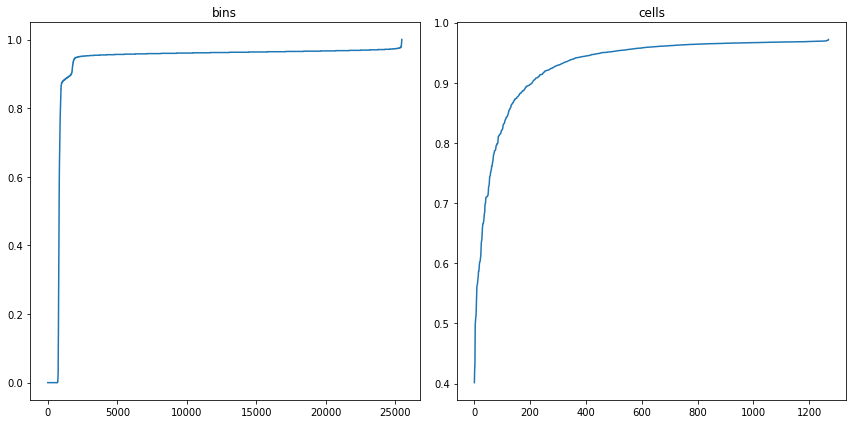

In [73]:
# evaluate the filtering process (what're kept)
baseline = df_c.mean(axis=1)
exp = condition.values*baseline.values
fig, axs = plt.subplots(3, 1, figsize=(20,12))
ax = axs[0]
title = '''m{}; base call cutoff = {}
        sufficient coverage fraction = {}
        base call cutoff2 = {}
        sufficient coverage fraction2 = {}
        high_mean = {}'''.format(context, base_call_cutoff, sufficient_coverage_fraction, 
                                 base_call_cutoff_v2, sufficient_coverage_fraction_v2, high_mean)
ax.set_title(title)
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax = axs[1]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 5000])
ax = axs[2]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 1500])
# plt.savefig('./results/pre')
plt.show()


# evalute after the filtering
# flag these cells
fig, axs = plt.subplots(1, 2, figsize=(12,6))
ax = axs[0]
sns.distplot(fbins, ax=ax, norm_hist=True)
ax.set_xlabel('Fraction of cells passing cutoff coverage for that bin')
ax.set_title('bins')

ax = axs[1]
sns.distplot(fcells, ax=ax, norm_hist=True)
ax.set_xlabel('Fraction of bins passing cutoff coverage for that cell')
ax.set_title('cells')
fig.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.plot(fbins.sort_values().values)
ax.set_title('bins')

ax = axs[1]
ax.plot(fcells.sort_values().values)
ax.set_title('cells')
fig.tight_layout()



In [74]:
# run 2d parameter searching colored by fraction of bins and fraction of cells included
ti = time.time()
bcf = np.arange(0, 200.1, 50) 
scf_bin = np.arange(0.9, 1.001, 0.01)
paras_bin = itertools.product(bcf, scf_bin)

res_bin = []
for i, (base_call_cutoff, sufficient_coverage_fraction) in enumerate(paras_bin):
    # low coverage condition
    print('.', end='')
    condition_bin = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
    # fraction of bins included
    res = np.sum(condition_bin.values*1)/df_c.shape[0]
    res_bin.append({'bcf': base_call_cutoff,
                     'scf': sufficient_coverage_fraction, 
                     'res': res})

tf = time.time()
print("time: {} sec".format(tf - ti))


ti = time.time()
bcf = np.arange(0, 200, 50) 
scf_cell = np.arange(0.9, 1.001, 0.01)
paras_cell = itertools.product(bcf, scf_cell)

res_cell = []
for i, (base_call_cutoff, sufficient_coverage_fraction) in enumerate(paras_cell):
    # low coverage condition
    print('.', end='')
    condition_cell = (df_c > base_call_cutoff).sum(axis=0) >= sufficient_coverage_fraction*df_c.shape[0] 
    # fraction of bins included
    res = np.sum(condition_cell.values*1)/df_c.shape[1]
    res_cell.append({'bcf': base_call_cutoff,
                     'scf': sufficient_coverage_fraction, 
                     'res': res})

tf = time.time()
print("time: {} sec".format(tf - ti))



.......................................................time: 48.879847288131714 sec
............................................time: 38.24678993225098 sec


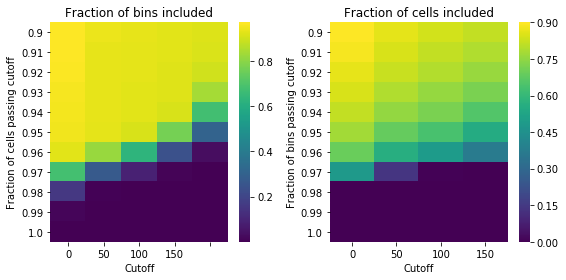

In [75]:
df_res_bin = pd.DataFrame(res_bin)
df_res_bin = pd.pivot_table(df_res_bin, values='res', index='scf', columns='bcf')

df_res_cell = pd.DataFrame(res_cell)
df_res_cell = pd.pivot_table(df_res_cell, values='res', index='scf', columns='bcf')

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
sns.heatmap(df_res_bin, cmap='viridis', ax=ax)
ax.set_title('Fraction of bins included')
ax.set_ylabel('Fraction of cells passing cutoff')
ax.set_xlabel('Cutoff')

ax.set_xticklabels(bcf)
ax.set_yticklabels([str(val)[:4] for val in scf_bin])
ax = axs[1]
sns.heatmap(df_res_cell, cmap='viridis', ax=ax)
ax.set_title('Fraction of cells included')
ax.set_ylabel('Fraction of bins passing cutoff')
ax.set_xlabel('Cutoff')
ax.set_xticklabels(bcf)
ax.set_yticklabels([str(val)[:4] for val in scf_cell])
fig.tight_layout()
plt.show()

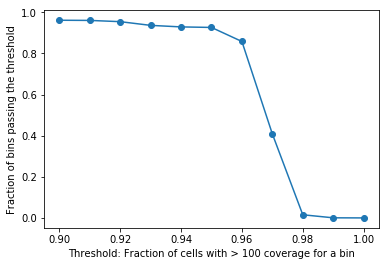

In [117]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

scf = np.arange(0.90, 1.001, 0.01)
res_list = []
base_call_cutoff = 100 
for sufficient_coverage_fraction in scf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
    # summarized condition
    condition = condition1 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of cells with > {} coverage for a bin'.format(base_call_cutoff))
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

...........

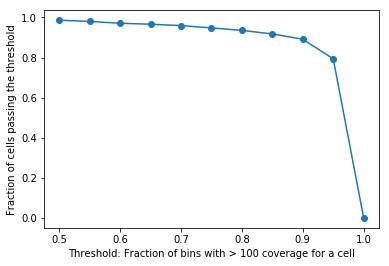

In [114]:
scf = np.arange(0.5, 1.01, 0.05)
res_list = []
base_call_cutoff = 100 
for sufficient_coverage_fraction in scf:
    # low coverage
    print('.', end='')
    condition1 = (df_c > base_call_cutoff).sum(axis=0) >= sufficient_coverage_fraction*df_c.shape[0] 
    # summarized condition
    condition = condition1 
    # fraction of bins included
    res = np.sum(condition.values*1)/df_c.shape[1]
    res_list.append(res)


# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of bins with > {} coverage for a cell'.format(base_call_cutoff))
ax.set_ylabel('Fraction of cells passing the threshold')
plt.show()

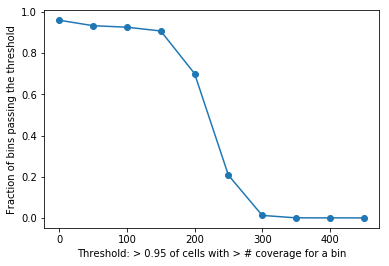

In [64]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

sufficient_coverage_fraction = 0.95
high_mean = 1200
res_list = []
bcf = np.arange(0, 500, 50) 
for base_call_cutoff in bcf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
    # high coverage
    condition2 = df_c.mean(axis=1) < high_mean 
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(bcf, res_list, '-o')
ax.set_xlabel('Threshold: > {} of cells with > # coverage for a bin'.format(sufficient_coverage_fraction))
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

In [76]:
# choose a condition to move forward

context = 'CH'
# low coverage
base_call_cutoff = 100 
sufficient_coverage_fraction = 0.95

base_call_cutoff_v2 = 100 
sufficient_coverage_fraction_v2 = 0.88

high_mean = 1200

condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
condition3 = (df_c > base_call_cutoff_v2).sum(axis=1) >= sufficient_coverage_fraction_v2*df_c.shape[1] 
# high coverage
condition2 = df_c.mean(axis=1) < high_mean 
condition = ((condition1 | (condition3 & (df_c.index.get_level_values(0)=='X'))) & condition2)

df_f = df.loc[condition]
print("Matrix size before pruning... "+ str(df.shape))
print("Matrix size after pruning... "+ str(df_f.shape))
print("Fraction of bins passing thresholds: "+ str(df_f.shape[0]/df.shape[0]))
print("Matrix size before pruning for chrX... "+ str(df[df.index.get_level_values(0)=='X'].shape))
print("Matrix size after pruning for chrX... "+ str(df_f[df_f.index.get_level_values(0)=='X'].shape))
print("Fraction of bins passing thresholds for chrX: "+ 
      str(df_f[df_f.index.get_level_values(0)=='X'].shape[0]/df[df.index.get_level_values(0)=='X'].shape[0]))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
nonnulls = 1 - df_c_nan.isnull()
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]

fbins = nonnulls.sum(axis=1)/nonnulls.shape[1]
fcells = nonnulls.sum(axis=0)/nonnulls.shape[0]

print("Mean cells {}".format(fbins.mean()))
print("Mean bins {}".format(fcells.mean()))


# normalization (normalized by global mcc)
print('Normalization...')
df_mcc = normalize_by_global(df_mcc, df_meta, context)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'
print('Done preprocess bins...')

Matrix size before pruning... (25475, 2540)
Matrix size after pruning... (23807, 2540)
Fraction of bins passing thresholds: 0.9345240431795878
Matrix size before pruning for chrX... (855, 2540)
Matrix size after pruning for chrX... (610, 2540)
Fraction of bins passing thresholds for chrX: 0.7134502923976608
Mean cells 0.9288673935385162
Mean bins 0.9288673935385161
Normalization...
Normalize by global mCH ...
Imputing data...
Done preprocess bins...


In [77]:
# try tSNE by 

# remove those cells (0.9 bins)
# mark those cells (generate confidence table)

print(df_mcc.shape)
df_mcc.head()
output_file = os.path.join(ens_path, 'binc/binc_m{}_norm_{}_{}.tsv'.format(context, ens, 10*BIN_SIZE))
print(output_file)

(23807, 1270)
/cndd/Public_Datasets/CEMBA/Ensembles/Ens2/binc/binc_mCH_norm_Ens2_100000.tsv


In [83]:
# 50 PC and tsne

def run_tsne(df, perp, n_pc=50, n_tsne=2, 
             random_state=1, output_file=None):
   
    ti = time.time()
    
    df = df.filter(regex='_mcc$')
    logging.info("Running tsne: {} PC and {} tSNE.\nInput shape: {}".format(n_pc, n_tsne, df.shape))
    
    pca = PCA(n_components=n_pc, random_state=random_state)
    pcs = pca.fit_transform(df.T)

    tsne = TSNE(n_components=n_tsne, init='pca', random_state=random_state, perplexity=perp, verbose=3)
    ts = tsne.fit_transform(pcs)
    
    df_tsne = pd.DataFrame(ts, columns=['tsne_x','tsne_y'])
    df_tsne['sample'] = [sample[:-len('_mcc')] for sample in df.columns.tolist()]
    df_tsne = df_tsne.set_index('sample')
    
    if output_file:
        logging.info("Saving output to file.")
        df_tsne.to_csv(output_file, sep="\t", na_rep='NA', header=True, index=True)

    tf = time.time()
    logging.info("Done with tSNE. running time: %.2f seconds." % (tf - ti))
    
    return df_tsne


In [84]:
df_tsne = run_tsne(df_mcc, perp=30)
print(df_tsne.shape)
print(df_tsne.head())

df_tsne_v2 = run_tsne(df_mcc[fcells[fcells>=0.9].index.values+'_mcc'], perp=30)
print(df_tsne_v2.shape)
print(df_tsne_v2.head())

02/01/2018 11:00:10 AM Running tsne: 50 PC and 2 tSNE.
Input shape: (23807, 1270)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1270 samples in 0.002s...
[t-SNE] Computed neighbors for 1270 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1270
[t-SNE] Computed conditional probabilities for sample 1270 / 1270
[t-SNE] Mean sigma: 7.730159
[t-SNE] Computed conditional probabilities in 0.073s
[t-SNE] Iteration 50: error = 47.9537163, gradient norm = 0.1446061 (50 iterations in 0.975s)
[t-SNE] Iteration 100: error = 49.4060059, gradient norm = 0.1062112 (50 iterations in 0.883s)
[t-SNE] Iteration 150: error = 48.8191452, gradient norm = 0.1065032 (50 iterations in 1.003s)
[t-SNE] Iteration 200: error = 49.3781242, gradient norm = 0.0847713 (50 iterations in 1.076s)
[t-SNE] Iteration 250: error = 49.7114792, gradient norm = 0.0849748 (50 iterations in 1.068s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.711479
[t-SNE] Iteration 300: error = 0.5448442, gradient norm = 0.0012039 (50 iterations in 0.935s)

02/01/2018 11:00:32 AM Done with tSNE. running time: 22.61 seconds.
02/01/2018 11:00:32 AM Running tsne: 50 PC and 2 tSNE.
Input shape: (23807, 1063)


[t-SNE] Iteration 1000: error = 0.4457810, gradient norm = 0.0001771 (50 iterations in 0.888s)
[t-SNE] Error after 1000 iterations: 0.445781
(1270, 2)
                                                       tsne_x     tsne_y
sample                                                                  
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...  -4.457003  27.971182
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...   3.330477  21.413570
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...  12.888856 -34.434975
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1... -37.846001  40.286564
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3... -41.197311  38.014969
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1063 samples in 0.001s...
[t-SNE] Computed neighbors for 1063 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1063
[t-SNE] Computed conditional probabilities for sample 1063 / 1063
[t-SNE] Mean sigma: 9.131696
[t-SNE] Computed conditional probabi

02/01/2018 11:00:50 AM Done with tSNE. running time: 18.21 seconds.


[t-SNE] Iteration 1000: error = 0.3641007, gradient norm = 0.0001066 (50 iterations in 0.731s)
[t-SNE] Error after 1000 iterations: 0.364101
(1063, 2)
                                                       tsne_x     tsne_y
sample                                                                  
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...  13.355562  -3.164927
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...   9.122512  16.022856
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...   9.782786 -50.106400
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...   9.469485  20.890984
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1...  11.660891  17.471415


In [85]:
df_conf = fcells.to_frame()
df_conf.columns = ['conf']
df_conf.head()

,conf
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A10_AD001_indexed,0.966830
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A10_AD002_indexed,0.966438
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A10_AD004_indexed,0.966320
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A10_AD006_indexed,0.968400
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_A10_AD007_indexed,0.934171


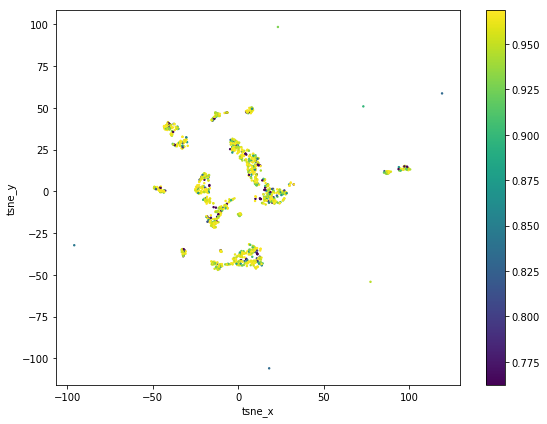

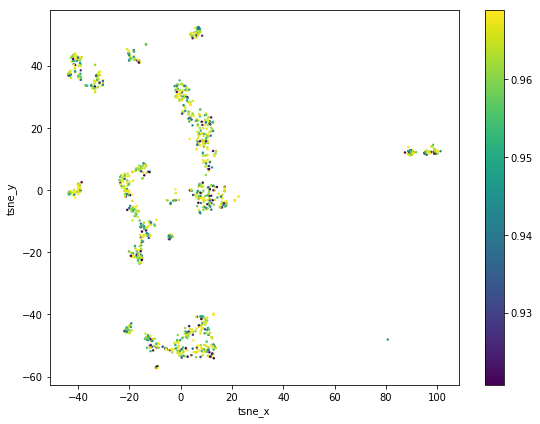

In [86]:
# visualize
df_plot = pd.merge(df_tsne, df_conf, left_index=True, right_index=True) 
plot_tsne_values(df_plot, tc='conf', low_p=5, hi_p=95)
df_plot = pd.merge(df_tsne_v2, df_conf, left_index=True, right_index=True) 
plot_tsne_values(df_plot, tc='conf', low_p=5, hi_p=95)

In [82]:
# df_mcc.iloc[:5,:5]
# output_file = './data/binc/binc_mCH_human_combined_100000_summary_nmcc_v4.tsv'

# df_mcc.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)

# mCG 

In [2]:
# mcg file
context = 'CG'
input_file = './data/binc/binc_mCG_human_combined_100000_summary.tsv'
df = pd.read_table(input_file, index_col=['chr', 'bin'], 
                       dtype={'chr': object})
print(df.shape)

# metadata
meta_file = './data/metadata/metadata_human_combined_updated.tsv'
df_meta = pd.read_table(meta_file, index_col='Sample')
print(df_meta.shape)

(30353, 12870)
(6435, 16)


In [3]:
df_mc = df.filter(regex='_mc$')
df_c = df.filter(regex='_c$')

df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 

print(df_mc.shape)
print(df_c.shape)

(30353, 6435)
(30353, 6435)


In [16]:
# Filter out bins with low and high coverage ...
# Keep only bins that have sufficient coverage in at least 99.5% of all cells

# low coverage
base_call_cutoff = 10 
sufficient_coverage_fraction = 0.95
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 500

condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
# df_c_nan = df_c.copy()
# df_c_nan[df_c < base_call_cutoff] = np.nan
# df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]

Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (23022, 12870)


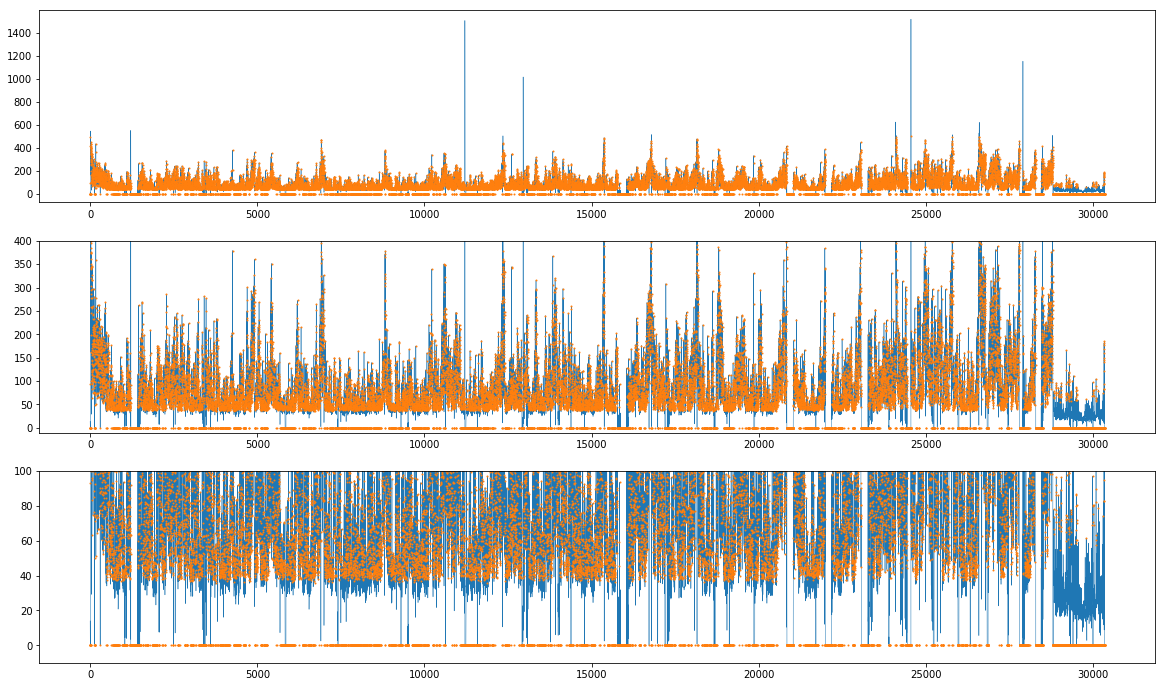

In [18]:
# evaluate the filtering process (what're kept)
baseline = df_c.mean(axis=1)
exp = condition.values*baseline.values
fig, axs = plt.subplots(3, 1, figsize=(20,12))
ax = axs[0]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax = axs[1]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([-10, 400])
ax = axs[2]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([-10, 100])
# plt.savefig('./results/pre')
plt.show()


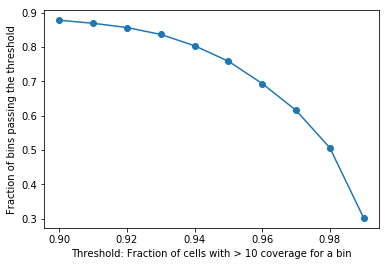

In [6]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

scf = np.arange(0.9, 1, 0.01)
res_list = []
base_call_cutoff = 10 
for sufficient_coverage_fraction in scf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
    # high coverage
    condition2 = df_c.mean(axis=1) < 500
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of cells with > %d coverage for a bin' % base_call_cutoff)
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

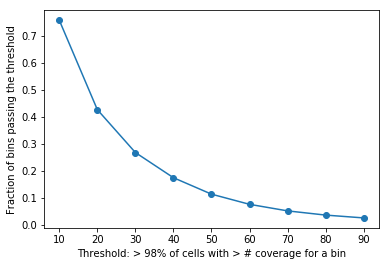

In [19]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

sufficient_coverage_fraction = 0.95
res_list = []
bcf = np.arange(10, 100, 10) 
for base_call_cutoff in bcf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
    # high coverage
    condition2 = df_c.mean(axis=1) < 500
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(bcf, res_list, '-o')
ax.set_xlabel('Threshold: > 98% of cells with > # coverage for a bin')
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

In [35]:
# choose a condition to move forward

# low coverage
base_call_cutoff = 10 
sufficient_coverage_fraction = 0.95
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 500

condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]


# normalization (normalized by global mcc)
print('Normalization...')
df_mcc = normalize_by_global(df_mcc, df_meta, 'CG')

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'

Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (23022, 12870)
Normalization...
Normalize by global mCG ...
Imputing data...


In [36]:
df_mcc.iloc[:5,:5]

output_file = './data/binc/binc_mCG_human_combined_100000_summary_nmcc_v4.tsv'
df_mcc.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)

# mCH and mCG

In [37]:
# concatenate mCH and mCG normalize each feature by its standard deviation

input_mch = './data/binc/binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
input_mcg = './data/binc/binc_mCG_human_combined_100000_summary_nmcc_v3.tsv'

df_mch = pd.read_table(input_mch, index_col=['chr', 'bin'], dtype={'chr': object})
df_mcg = pd.read_table(input_mcg, index_col=['chr', 'bin'], dtype={'chr': object})

print(df_mch.shape)
print(df_mcg.shape)

(26058, 6435)
(23022, 6435)


In [38]:
df_mcg.iloc[:5, :5]


170508_MB_EA_hs_58yr_BA10_pool_1873_AD006_indexed_mcc  \
chr bin                                                              
1   700000                                            0.714391       
    800000                                            0.664107       
    900000                                            0.878970       
    1000000                                           0.890401       
    1300000                                           0.735449       

             170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed_mcc  \
chr bin                                                              
1   700000                                            0.955908       
    800000                                            0.576582       
    900000                                            0.770839       
    1000000                                           0.852254       
    1300000                                           0.571559       

             170508_MB_EA_hs_58yr_BA10_pool_1875_AD010_indexed_mcc  \
chr bin                                                              
1   700000                                            0.679535       
    800000                                            0.721382       
    900000                                            0.759906       
    1000000                                           1.185750       
    1300000                                           0.866408       

             170508_MB_EA_hs_58yr_BA10_pool_1876_AD006_indexed_mcc  \
chr bin                                                              
1   700000                                            1.138203       
    800000                                            0.450539       
    900000                                            0.790691       
    1000000                                           0.945814       
    1300000                                           0.572116       

             170508_MB_EA_hs_58yr_BA10_pool_1876_AD010_indexed_mcc  
chr bin                                                             
1   700000                                            0.609411      
    800000                                            0.485902      
    900000                                            0.845514      
    1000000                                           1.001423      
    1300000                                           0.885802

In [53]:
# get an overall standard deviation
std_mch = df_mch.stack().std()
std_mcg = df_mcg.stack().std()
print(std_mch, std_mcg)

# normalize by over all standard deviation
df_nmch = df_mch/std_mch
df_nmcg = df_mcg/std_mcg
std_nmch = df_nmch.stack().std()
std_nmcg = df_nmcg.stack().std()
print(std_nmch, std_nmcg)

0.366409291454 0.191068640493
1.0 1.0


In [54]:
df_mchmcg = pd.concat([df_nmch, df_nmcg])
print(df_mchmcg.shape)

(49080, 6435)


In [57]:
df_mchmcg.iloc[-5:, :5]

160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.483203      
    153300000                                           1.035434      
    153500000                                           0.794306      
    153600000                                           0.672916      
    153700000                                           0.696927      

               160729_MB_v1_hs_25yr_MFG_pool_1000_AD010_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.688674      
    153300000                                           0.530839      
    153500000                                           0.696273      
    153600000                                           0.582504      
    153700000                                           0.679731      

               160729_MB_v1_hs_25yr_MFG_pool_1001_AD008_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.942488      
    153300000                                           0.912989      
    153500000                                           1.158912      
    153600000                                           0.699804      
    153700000                                           0.920928      

               160729_MB_v1_hs_25yr_MFG_pool_1001_AD010_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.639658      
    153300000                                           1.173519      
    153500000                                           1.081323      
    153600000                                           0.847459      
    153700000                                           1.218746      

               160729_MB_v1_hs_25yr_MFG_pool_1002_AD010_indexed_mcc  
chr bin                                                              
X   153200000                                           0.981912     
    153300000                                           1.135154     
    153500000                                           1.045523     
    153600000                                           0.551984     
    153700000                                           1.176657

In [58]:
output_file = './data/binc/binc_mCHmCG_human_combined_100000_summary_nmcc_v4.tsv'
df_mchmcg.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)